# Tugas 5: Page rank Web Informatika

## Import package

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt 

## Membaca data dari file .txt

In [2]:
df = pd.read_csv('dataset/informatika_web.csv') # Baris yang diawali '#' (seperti deskripsi) diabaikan

## Fungsi Manual

In [3]:
def pagerank(adj_matrix, d=0.85, max_iter=100, tol=1e-6):
    """
    Hitung PageRank dari matriks adjacency.
    
    Parameters:
        adj_matrix : array-like, shape (n, n)
            Matriks adjacency (1 jika ada link i -> j)
        d : float
            Damping factor (default: 0.85)
        max_iter : int
            Maksimum iterasi
        tol : float
            Toleransi konvergensi
    
    Returns:
        r : ndarray, shape (n,)
            Vektor PageRank
    """
    adj = np.array(adj_matrix, dtype=float)
    n = adj.shape[0]
    
    # Tangani dangling nodes (baris dengan jumlah 0)
    out_degree = np.sum(adj, axis=1)
    for i in range(n):
        if out_degree[i] == 0:
            adj[i, :] = 1.0  # taut ke semua halaman
    
    # Normalisasi baris → jadi matriks transisi (baris jumlah = 1)
    # TAPI: PageRank asli menggunakan TRANSPOSE → aliran masuk
    # Jadi kita transpos untuk membuat kolom = out-link
    M = adj / np.sum(adj, axis=1, keepdims=True)
    M = M.T  # Sekarang M[j,i] = probabilitas dari i ke j
    
    # Inisialisasi
    r = np.ones(n) / n
    teleport = (1 - d) / n
    
    for _ in range(max_iter):
        r_new = d * M @ r + teleport
        if np.linalg.norm(r_new - r, 1) < tol:
            break
        r = r_new
    
    return r


### 2. Mapping node ID menjadi index

In [4]:
# Membuat index unik untuk node
nodes = pd.Index(sorted(set(df['FromNodeId']).union(set(df['ToNodeId']))))
node_to_index = {node: i for i, node in enumerate(nodes)}

# Mapping ke index
df['from_index'] = df['FromNodeId'].map(node_to_index)
df['to_index'] = df['ToNodeId'].map(node_to_index)
print(df.head())


                                          FromNodeId  \
0               https://informatika.trunojoyo.ac.id/   
1               https://informatika.trunojoyo.ac.id/   
2               https://informatika.trunojoyo.ac.id/   
3  https://informatika.trunojoyo.ac.id/bidang-min...   
4  https://informatika.trunojoyo.ac.id/bidang-min...   

                                            ToNodeId  from_index  to_index  
0               https://informatika.trunojoyo.ac.id/           2         2  
1               https://informatika.trunojoyo.ac.id/           2         2  
2  https://informatika.trunojoyo.ac.id/bidang-min...           2        11  
3               https://informatika.trunojoyo.ac.id/          11         2  
4  https://informatika.trunojoyo.ac.id/bidang-min...          11        11  


### Buat adjacency matrix

In [5]:
n = len(nodes)
adj_matrix = lil_matrix((n, n))

for _, row in df.iterrows():
    adj_matrix[row['from_index'], row['to_index']] = 1

adj_matrix = adj_matrix.toarray()


### Hitung PageRank

In [6]:
pr = pagerank(adj_matrix)
print("Top 10 PageRank scores:")
top_nodes = pr.argsort()[-10:][::-1]
for idx in top_nodes:
    print(f"Node ID asli {nodes[idx]} punya PageRank = {pr[idx]:.6f}")


Top 10 PageRank scores:
Node ID asli https://informatika.trunojoyo.ac.id/laboratorium-teknik-informatika/lab-003 punya PageRank = 0.016586
Node ID asli https://informatika.trunojoyo.ac.id/ punya PageRank = 0.016586
Node ID asli https://informatika.trunojoyo.ac.id/bidang-minat/10 punya PageRank = 0.016586
Node ID asli https://informatika.trunojoyo.ac.id/bidang-minat/11 punya PageRank = 0.016586
Node ID asli https://informatika.trunojoyo.ac.id/bidang-minat/12 punya PageRank = 0.016586
Node ID asli https://informatika.trunojoyo.ac.id/bidang-minat/13 punya PageRank = 0.016586
Node ID asli https://informatika.trunojoyo.ac.id/laboratorium-teknik-informatika/lab-002 punya PageRank = 0.016586
Node ID asli https://informatika.trunojoyo.ac.id/laboratorium-teknik-informatika/lab-001 punya PageRank = 0.016586
Node ID asli https://labtif.sakera.id/dosen punya PageRank = 0.016586
Node ID asli https://informatika.trunojoyo.ac.id/dokumen-sop/14 punya PageRank = 0.015019


### 6. Export PageRank ke CSV

In [15]:
result = pd.DataFrame({
    "node_index": range(len(nodes)),
    "node_id_asli": nodes,
    "pagerank": pr
})
# result.to_csv("pagerank_result.csv", index=False)
# print("\n✅ Hasil PageRank disimpan ke pagerank_result.csv")

## Menggunakan fungsi Network

### Membuat Graph Terarah

In [8]:
G = nx.from_pandas_edgelist(df, 'FromNodeId', 'ToNodeId', create_using=nx.DiGraph())

### Menghitung PageRank

In [9]:
pagerank_scores = nx.pagerank(G, alpha=0.85)

### Mengubah hasil PageRank menjadi DataFrame

In [10]:
pagerank_df = pd.DataFrame(list(pagerank_scores.items()), 
                        columns=['NodeId', 'PageRank'])

### Mengurutkan DataFrame berdasarkan PageRank (dari terbesar ke terkecil)

In [11]:
pagerank_sorted = pagerank_df.sort_values(by='PageRank', ascending=False)

top_10_nodes = pagerank_sorted.head(10)

# 3. Menampilkan hasilnya
print("10 Node dengan PageRank Tertinggi:")
print(top_10_nodes)

10 Node dengan PageRank Tertinggi:
                                               NodeId  PageRank
0                https://informatika.trunojoyo.ac.id/  0.016586
2   https://informatika.trunojoyo.ac.id/bidang-min...  0.016586
3   https://informatika.trunojoyo.ac.id/bidang-min...  0.016586
4   https://informatika.trunojoyo.ac.id/bidang-min...  0.016586
5                      https://labtif.sakera.id/dosen  0.016586
6   https://informatika.trunojoyo.ac.id/laboratori...  0.016586
7   https://informatika.trunojoyo.ac.id/laboratori...  0.016586
8   https://informatika.trunojoyo.ac.id/laboratori...  0.016586
1   https://informatika.trunojoyo.ac.id/bidang-min...  0.016586
30  https://informatika.trunojoyo.ac.id/unit-kegia...  0.015019


## Visualisasi Grafik

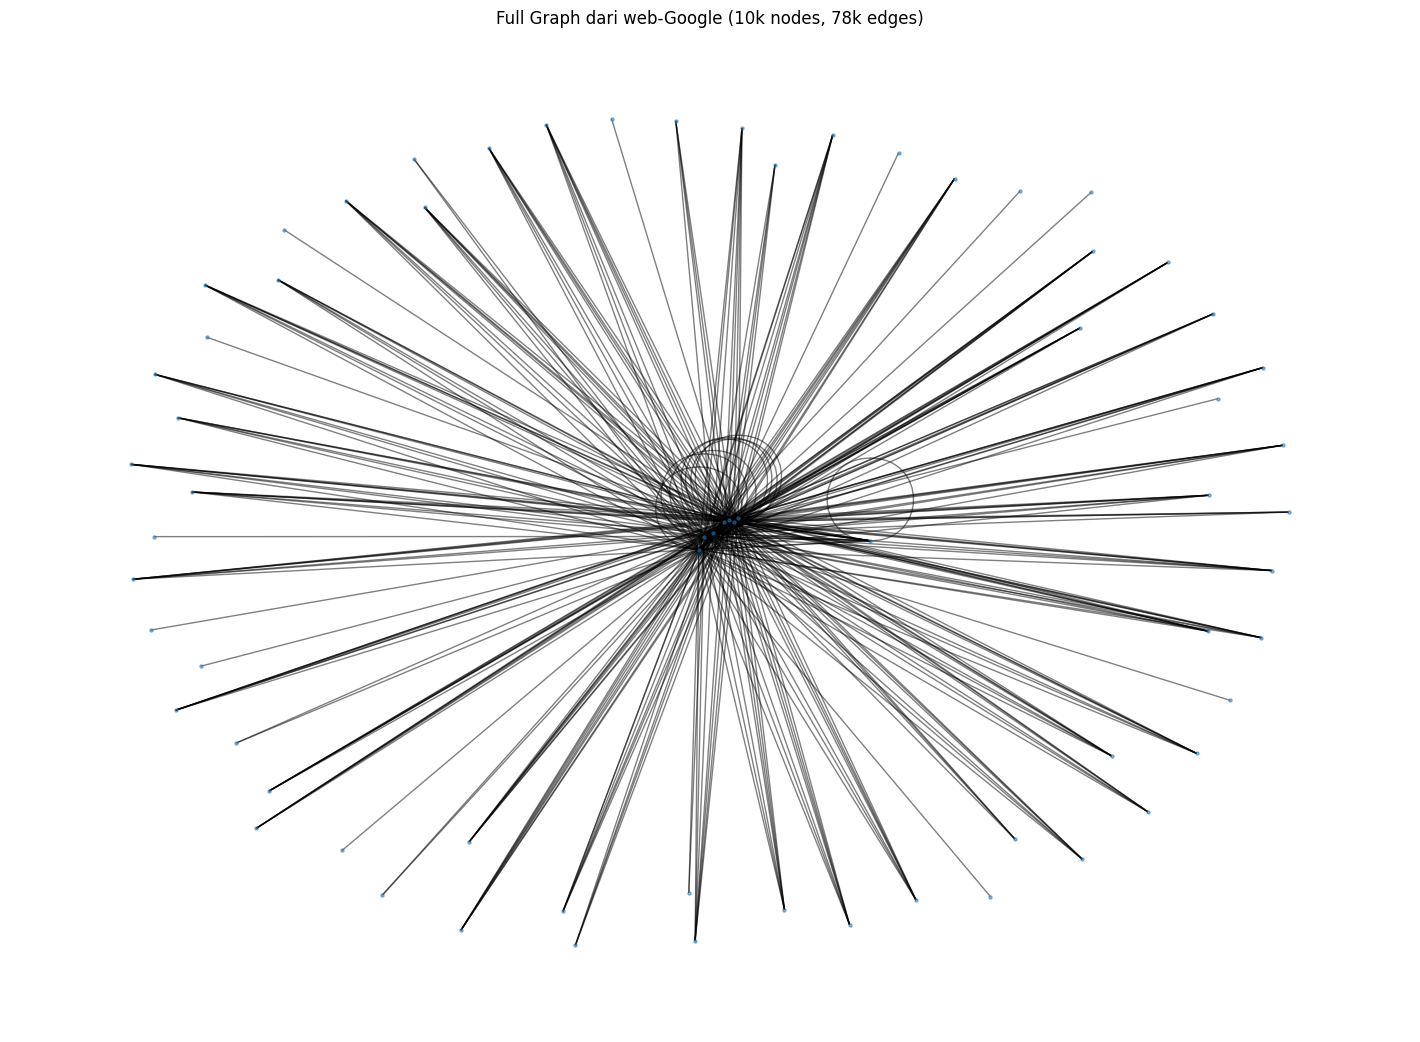

In [12]:
# Plot semua node dan edge (WARNING: sangat berat)
G = nx.from_pandas_edgelist(df, 'from_index', 'to_index', create_using=nx.DiGraph())
plt.figure(figsize=(14, 10))
nx.draw(G, node_size=5, arrows=False, alpha=0.5)
plt.title("Full Graph dari web-Google (10k nodes, 78k edges)")
plt.show()

### Plot 10 PageRank Teratas

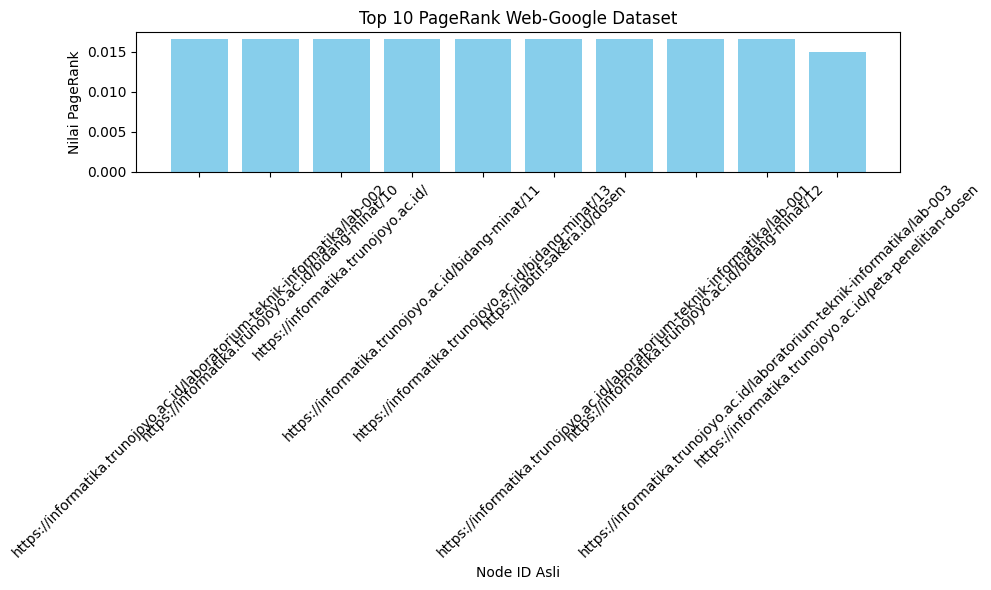

In [16]:
top10 = result.sort_values(by="pagerank", ascending=False).head(10)
plt.figure(figsize=(10,6))
plt.bar(top10['node_id_asli'].astype(str), top10['pagerank'], color='skyblue')
plt.xticks(rotation=45)
plt.title("Top 10 PageRank Web-Google Dataset")
plt.xlabel("Node ID Asli")
plt.ylabel("Nilai PageRank")
plt.tight_layout()
plt.show()